In [ ]:
# Refereces:
# https://www.tensorflow.org/tutorials/images/classification
#

In [1]:
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

DATA_FOLDER = './data/CNRParkData/A'
DATA_FOLDER_TEST = './data/CNRParkData/B'
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# load a dataset of the images, the dataset is a stream of a
# couple of tensor:
# -> image tensor size: batch_size x image_widht x image_height x image_channels
# -> label tensor size: batch_size x 1
#
# The images are organized in subfolders, each subfolder is a different category, p.e.:
# /root/
#       busy/
#       free/
#
def load_ds(subset=None, data_folder=DATA_FOLDER):
    if subset == None or subset == 'full':
        vsplit = 0.0
    else:
        vsplit = 0.2
        
    return tf.keras.utils.image_dataset_from_directory(
        data_folder,
        labels='inferred',
        label_mode='binary',
        class_names=('free','busy'),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(150,150),
        shuffle=True,
        seed=123,
        validation_split=vsplit,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )

train_ds = load_ds('training')
valid_ds = load_ds('validation')

class_names = train_ds.class_names #type: ignore
print(class_names)
print(f'Train DS size {len(train_ds.file_paths)}')
print(f'Valid DS size {len(valid_ds.file_paths)}')

Found 6171 files belonging to 2 classes.
Using 4937 files for training.
Found 6171 files belonging to 2 classes.
Using 1234 files for validation.


2023-04-03 14:38:35.448688: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 0 of dimension 0 out of bounds.


155
155
Train DS size 4937
('free', 'busy')
Train DS size 4937
Valid DS size 1234


2023-03-22 18:20:58.438128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


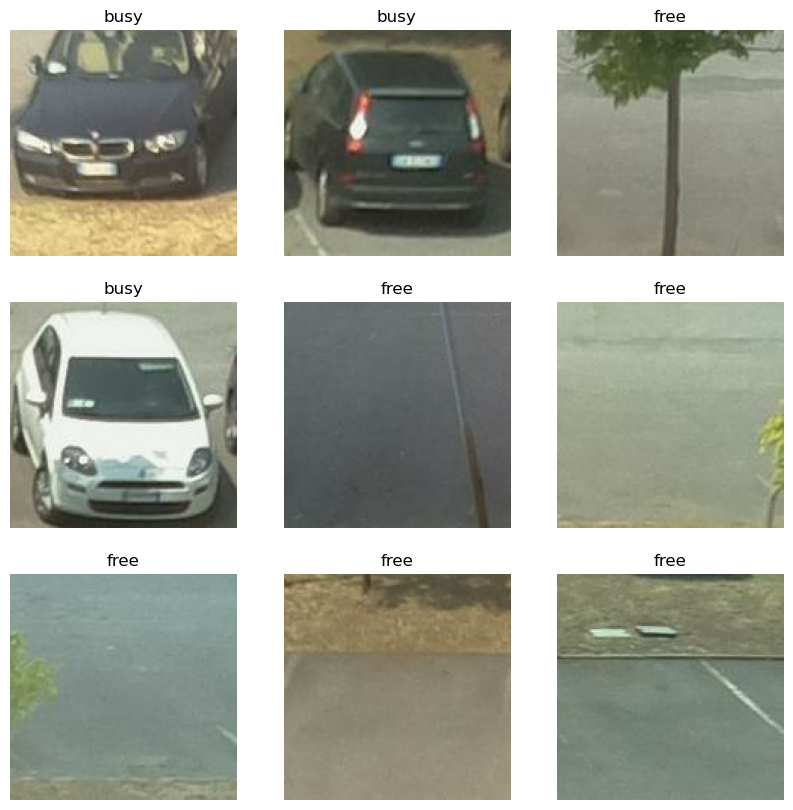

In [2]:
#imgs, lbls = next(iter(train_ds)) # get the first batch... or take it!
plt.figure(figsize=(10,10))
for imgs, lbls in train_ds.take(1):
    for i in range(9):
        img = imgs[i].numpy().astype('uint8') 
        lbl = lbls[i].numpy().astype('int')[0]
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis(False)


In [ ]:
# Standardize data & prepare a dataset
# https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

normalization_layer = Sequential([
    tf.keras.layers.Resizing(width=150, height=150),
    tf.keras.layers.Rescaling(1./255),  
])

def prepare_data(ds, shuffle=False, augmenter=None, batch_size=BATCH_SIZE):
    if shuffle:
        ds.shuffle(1000)
    
    if normalization_layer != None:
        ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    
    if augmenter != None:
        ds = ds.map(lambda x,y: (augmenter(x, training=True), y), num_parallel_calls=AUTOTUNE)

    return ds


In [ ]:
# ISSUE WITH AUGMENTERS!!
# https://github.com/tensorflow/tensorflow/issues/55639#issuecomment-1310229476
# there was a bunch of problem related with augmentation and keras
# implementation, the core problem same to be related with the vectorialized_map implementation
# as to date 8 gen 2023 the problem is still present...
#

augmentation_layer = Sequential([
    #layers.RandomFlip('vertical')
    #layers.RandomRotation(0.1),
    #layers.RandomTranslation(width_factor=0.5, height_factor=0.)
])

#train_nds = prepare_data(train_ds, augmenter=augmentation_layer)
train_nds = prepare_data(train_ds)

In [ ]:
plt.figure(figsize=(10,10))
for imgs, lbls in train_nds.take(1):
    for i in range(16):
        img = imgs[i].numpy() 
        lbl = lbls[i].numpy().astype('int')[0]
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis(False)


In [ ]:
model = Sequential([
    layers.Input((150, 150, 3)),
    layers.Rescaling(1./255),
    layers.Normalization(axis=[1]),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64),
    #layers.Dropout(0.3),
    layers.Dense(len(class_names))
])

In [ ]:
model.build()
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics =['accuracy']
)

model.summary()

In [ ]:
model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 3
)

In [ ]:
# Evaluate the trained model on a separate test ds
# !WARNING! there are a lot of misclassification in TEST folder data
#
test_ds = load_ds(subset=None, data_folder=DATA_FOLDER_TEST)
score = model.evaluate(test_ds)

## TOP ACCURACY ON TEST DATASET: 99.0/99.5/85.9 %

In [ ]:
# Evaluate the trainend model using the same 
# augmented dataset 

test_augmenter = Sequential([
    layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation,
    layers.RandomRotation(factor=30)
])